# notebook to explore extracted movie features from neuroscout with pyns
Uses jeffs pliers conda env

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("paper", "white")
from pyns import Neuroscout
import math

api = Neuroscout()

In [2]:
import dcor

In [4]:
datasets = api.datasets.get()
print(f'dataset count = {len(api.datasets.get())}\n')
print('Datasets and IDs:\n')
for i in datasets:
    print(i['name'], i['id'])

dataset count = 12

Datasets and IDs:

Raiders 10
studyforrest 11
SchematicNarrative 20
SherlockMerlin 5
Sherlock 21
narratives 30
LearningTemporalStructure 19
Budapest 27
Life 9
ParanoiaStory 18
NaturalisticNeuroimagingDatabase 28
ReadingBrainProject 29


In [5]:
# ParanoiStory (audio only) LearningTemporalStructure and ReadingBrainProject should be excluded

#### get the id of a subject from healthy brain network, Despicable Me

In [6]:
subject = api.runs.get(dataset_id=8)[0]['subject']

### let's just look at budapest to start

In [8]:
api.runs.get(dataset_id=8, subject=subject)

[{'acquisition': None,
  'dataset_id': 8,
  'duration': 600.0000089406967,
  'id': 211,
  'number': None,
  'session': None,
  'subject': 'NDARYX592YYR',
  'task': 7,
  'task_name': 'movieDM'}]

In [11]:
#get the run number for just BUDAPEST, SUBJECT5, PART1
run_id=api.runs.get(dataset_id=8, subject=subject)[0]['id']
run_duration=api.runs.get(dataset_id=8, subject=subject)[0]['duration']

### get just the non-fmriprep predictors and those that have a calculated mean (floats, ints, binary, etc)

In [12]:
def get_predictors(run_id):
    # input: a neuroscout run_id 
    # outputs:
    # - a pandas dataframe of predictors
    # - list of ids
    # - list of names
    # - list of modality
    predictors=api.predictors.get(run_id=run_id)
    predictor_ids = []
    predictor_names = []
    predictor_modality = []
    for i in predictors:
        if not i['source'] == 'fmriprep' and not i['mean'] == None and str(i['name']).find("bert") < 0:
            predictor_ids.append(i['id'])
            predictor_names.append(i['name'])
            try:
                predictor_modality.append(i['extracted_feature']['modality'])
            except:
                predictor_modality.append(None)
                
    df_predictors=pd.DataFrame(data= np.array([predictor_ids,predictor_modality,predictor_names]).T , columns=['id','modality','names'])
    df_predictors = df_predictors.sort_values(by=['id','names','modality'])
    predictor_ids= df_predictors['id'].to_numpy()
    predictor_names= df_predictors['names'].to_numpy()
    predictor_modality= df_predictors['modality'].to_numpy()



    return(df_predictors, predictor_ids, predictor_names, predictor_modality)

In [13]:
df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)

### load into pandas df, sort predictors by id, name, modality

#### how many values are in each predictor??

load an event into df, sort it by onset

In [14]:
def get_timeseries(predictor_ids,run_id,run_duration):
    # input: list of predictor IDs
    # output: an array of predictors as 1 hz timeseries
    #
    ### given an event... convert it from duration onset value to timeseries
    # - sort it (the dicts are out of order)
    # - convert to timeseries
    # - resample it to 1 hz now as a start
    all_feats = []
    for pred_id in predictor_ids:
        an_event=api.predictor_events.get(predictor_id=pred_id,run_id=run_id,stimulus_timing=True)
        data = np.zeros((int(run_duration)))
        for i in an_event:
            start = round(i['onset'])
            stop = start + math.ceil(i['duration'])
            value = i['value']
            #onset=round(onset)
            try:
                data[start:stop]=value
            except:
                #print()
                print(f'skipped {value}')

        all_feats.append(data)
    all_feats = np.asarray(all_feats)
    return(all_feats)
    #all_feats is length = # predictors each predictor is size = run duration

In [15]:
all_feats = get_timeseries(predictor_ids,run_id,run_duration)

df = pd.DataFrame(data=all_feats.T,columns =predictor_names)

## which predictors are common to all av clips?

In [13]:
#dataset_ids = [27,28,8,20,11,10,9,21,5]
#dataset_names = ['Budapest','NaturalisticNeuroimagingDatabase','HealthyBrainNetwork','SchematicNarrative','studyforrest','Raiders','Life','Sherlock','SherlockMerlin']
dataset_ids = [27,8,20,11,10,9,21,5]
dataset_names = ['Budapest','HealthyBrainNetwork','SchematicNarrative','studyforrest','Raiders','Life','Sherlock','SherlockMerlin']


In [14]:
predictor_list_list = []
predictor_names_list = []
for i,d in enumerate(dataset_ids):
    subject = api.runs.get(dataset_id=d)[0]['subject']
    #print(subject)
    run_id=api.runs.get(dataset_id=d, subject=subject)[0]['id']
    #print(run_id)
    run_duration=api.runs.get(dataset_id=d, subject=subject)[0]['duration']
    
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)
    predictor_list_list.append(predictor_ids)
    predictor_names_list.append(predictor_names)

In [ ]:
for i,d in enumerate(dataset_ids):
    print(dataset_names[i])
    print(predictor_names_list[i])

In [16]:
predictor_names_intersect = predictor_names_list[0].copy()

for i in predictor_names_list[1:]:
    predictor_names_intersect = np.intersect1d(predictor_names_intersect,i)
   # print(predictor_names_intersect)
predictor_names_intersect

array(['0 0 2', '0 1 57', '0 25 67', ..., 'wood', 'word_count', 'writing'],
      dtype=object)

In [17]:
predictor_names_intersect[:100]

array(['0 0 2', '0 1 57', '0 25 67', '1 1 3', '10 14 24', '10 17 7',
       '10 17 8', '10 19 9', '10 24 44', '10 25 44', '10 26 46', '10 3 2',
       '10 3 4', '10 5 5', '10 5 7', '10 7 11', '10 9 10', '10 9 16',
       '100 10 17', '100 120 141', '100 158 184', '100 17 29',
       '100 17 30', '100 19 32', '100 32 30', '100 33 30', '100 44 16',
       '100 45 6', '100 46 6', '100 46 7', '100 63 43', '100 64 53',
       '100 65 40', '100 65 55', '100 66 53', '100 67 52', '100 69 47',
       '100 69 48', '100 69 54', '100 69 57', '100 70 46', '100 70 50',
       '100 70 52', '100 70 60', '100 71 49', '100 71 60', '100 72 56',
       '100 73 72', '100 75 25', '100 76 55', '100 77 50', '100 77 55',
       '100 77 57', '100 77 58', '100 77 65', '100 78 53', '100 79 55',
       '100 79 56', '100 79 57', '100 79 58', '100 79 60', '100 79 61',
       '100 79 62', '100 79 64', '100 79 65', '100 79 66', '100 79 67',
       '100 80 63', '100 80 64', '100 80 65', '100 80 66', '100 80 68',
      

## get all budapest parts ('number')

In [60]:
all_feats = []
for number in np.arange(5):
    number+=1
    run_id=api.runs.get(dataset_id=27, subject=subject,number=number)[0]['id']
    run_duration=api.runs.get(dataset_id=27, subject=subject,number=number)[0]['duration']
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)
    feats = get_timeseries(predictor_ids,run_id,run_duration)
    all_feats.append(feats)

In [63]:
all_feats[3].shape

(192, 618)

In [67]:
all_feats = np.concatenate(all_feats,axis=1)

In [68]:
all_feats.shape

(192, 3052)

In [74]:
df = pd.DataFrame(data=all_feats.T,columns =predictor_names)

## get naturalistic neuroimaging movies

In [18]:
subject = api.runs.get(dataset_id=28)[0]['subject']
subject

'81'

In [19]:
runs = api.runs.get(dataset_id=28)
task_list = []
task_names = []
run_ids = []
for r in runs:
    task_list.append(r['task'])
    task_names.append(r['task_name'])
    run_ids.append(r['id'])
task_list,ind = np.unique(np.asarray(task_list),return_index=True)

task_name_list = []
run_id_list = []
for i in ind:
    task_name_list.append(task_names[i])
    run_id_list.append(run_ids[i])
print(task_list)
print(task_name_list)
print(run_id_list)

[49 50 51 52 53 54 55 56 57 58]
['12yearsaslave', '500daysofsummer', 'backtothefuture', 'citizenfour', 'littlemisssunshine', 'pulpfiction', 'split', 'theprestige', 'theshawshankredemption', 'theusualsuspects']
[1558, 1581, 1584, 1590, 1608, 1614, 1620, 1626, 1632, 1638]


### plot dcorr for each

In [20]:
for i,run_id in enumerate(run_id_list):
    task_name = task_name_list[i]
    task = task_list[i]
    subject = api.runs.get(task_id=task)[0]['subject']
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)

In [21]:
predictor_names

array(['rms', 'vibrance', 'brightness', 'abstract', 'action', 'adult',
       'alphabet', 'animal', 'architecture', 'art', 'blur', 'building',
       'business', 'car', 'child', 'city', 'color', 'competition',
       'creativity', 'dark', 'daylight', 'design', 'desktop', 'empty',
       'equipment', 'face', 'family', 'fashion', 'furniture', 'girl',
       'hand', 'home', 'horizontal', 'illustration', 'image', 'indoors',
       'landscape', 'light', 'man', 'military', 'music', 'nature', 'old',
       'one', 'outdoors', 'pattern', 'people', 'portrait', 'recreation',
       'retro', 'road', 'room', 'simplicity', 'sky', 'street', 'summer',
       'sunset', 'technology', 'text', 'travel', 'two', 'vehicle',
       'vertical', 'water', 'wear', 'wild', 'wildlife', 'woman', 'wood',
       'writing', 'spectral_centroid', 'tonal_centroid_0',
       'tonal_centroid_1', 'tonal_centroid_2', 'tonal_centroid_3',
       'tonal_centroid_4', 'tonal_centroid_5', 'chroma_cqt_0',
       'chroma_cqt_1', 'chr

In [121]:
import dcor

for i,run_id in enumerate(run_id_list):
    task_name = task_name_list[i]
    task = task_list[i]
    subject = api.runs.get(task_id=task)[0]['subject']
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)
    
    all_feats = get_timeseries(predictor_ids,run_id,run_duration)

    df = pd.DataFrame(data=all_feats.T,columns =predictor_names)
    
    %time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
    dcor_matrix = result.values
    g = sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
    g.fig.suptitle(f'{task_name}, dcor clustermap')
    plt.savefig(f'../outputs/dcor_{task_name}.png')
    plt.close()

CPU times: user 37.4 s, sys: 11.2 ms, total: 37.4 s
Wall time: 37.5 s
CPU times: user 37.7 s, sys: 9.95 ms, total: 37.7 s
Wall time: 37.8 s
CPU times: user 38.1 s, sys: 9.58 ms, total: 38.1 s
Wall time: 38.2 s
CPU times: user 37 s, sys: 7.58 ms, total: 37 s
Wall time: 37.1 s
CPU times: user 36.9 s, sys: 7.1 ms, total: 36.9 s
Wall time: 37 s
CPU times: user 37.3 s, sys: 10.1 ms, total: 37.3 s
Wall time: 37.3 s
CPU times: user 37.4 s, sys: 9.36 ms, total: 37.4 s
Wall time: 37.5 s
CPU times: user 38.1 s, sys: 7.95 ms, total: 38.1 s
Wall time: 38.2 s
CPU times: user 36.8 s, sys: 4.24 ms, total: 36.8 s
Wall time: 36.9 s
CPU times: user 36.9 s, sys: 5 ms, total: 36.9 s
Wall time: 37 s


## plot dcor for all nat neuroimaging concatenated

In [183]:
import dcor

all_feats_concat = []

for i,run_id in enumerate(run_id_list):
    task_name = task_name_list[i]
    task = task_list[i]
    subject = api.runs.get(task_id=task)[0]['subject']
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)
    
    all_feats = get_timeseries(predictor_ids,run_id,run_duration)
    all_feats_concat.append(all_feats)

all_feats_concat = np.concatenate(all_feats_concat,axis=1)
print(all_feats_concat.shape)
df = pd.DataFrame(data=all_feats_concat.T,columns =predictor_names)

%time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
dcor_matrix = result.values

(91, 14530)
CPU times: user 38min 9s, sys: 1min 19s, total: 39min 28s
Wall time: 19min 46s


In [188]:
g = sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
g.fig.suptitle('dcor naturalistic_neuroimaging movies',size=30) 
plt.savefig(f'../outputs/dcor_naturalistic_neuroimaging_all.png')
plt.close()

## get sherlock / merlin

In [30]:
runs = api.runs.get(dataset_id=5)
task_list = []
task_names = []
run_ids = []
for r in runs:
    task_list.append(r['task'])
    task_names.append(r['task_name'])
    run_ids.append(r['id'])
task_list,ind = np.unique(np.asarray(task_list),return_index=True)

task_name_list = []
run_id_list = []
for i in ind:
    task_name_list.append(task_names[i])
    run_id_list.append(run_ids[i])
print(task_list)
print(task_name_list)
print(run_id_list)

[ 4 45]
['MerlinMovie', 'SherlockMovie']
[1410, 1428]


### plot dcorr for each

In [31]:
import dcor

for i,run_id in enumerate(run_id_list):
    task_name = task_name_list[i]
    task = task_list[i]
    subject = api.runs.get(task_id=task)[0]['subject']
    
    run_duration=api.runs.get(dataset_id=5, subject=subject)[0]['duration']
    
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)
    
    all_feats = get_timeseries(predictor_ids,run_id,run_duration)

    df = pd.DataFrame(data=all_feats.T,columns =predictor_names)
    
    %time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
    dcor_matrix = result.values
    sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
    plt.title(f'{task_name}, dcor clustermap')
    plt.savefig(f'../outputs/dcor_{task_name}.png')
    plt.close()

CPU times: user 6min 47s, sys: 192 ms, total: 6min 47s
Wall time: 6min 47s


/om2/user/jsmentch/anaconda/envs/pliers/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


CPU times: user 6min 30s, sys: 203 ms, total: 6min 31s
Wall time: 6min 31s


## get HBN

In [34]:
runs = api.runs.get(dataset_id=8)
task_list = []
task_names = []
run_ids = []
for r in runs:
    task_list.append(r['task'])
    task_names.append(r['task_name'])
    run_ids.append(r['id'])
task_list,ind = np.unique(np.asarray(task_list),return_index=True)

task_name_list = []
run_id_list = []
for i in ind:
    task_name_list.append(task_names[i])
    run_id_list.append(run_ids[i])
print(task_list)
print(task_name_list)
print(run_id_list)

[7]
['movieDM']
[211]


### plot dcorr

In [36]:
import dcor

for i,run_id in enumerate(run_id_list):
    task_name = task_name_list[i]
    task = task_list[i]
    subject = api.runs.get(task_id=task)[0]['subject']
    
    run_duration=api.runs.get(dataset_id=8, subject=subject)[0]['duration']
    
    df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)
    
    all_feats = get_timeseries(predictor_ids,run_id,run_duration)

    df = pd.DataFrame(data=all_feats.T,columns =predictor_names)
    
    %time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
    dcor_matrix = result.values
    g = sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
    g.fig.suptitle(f'HBN {task_name}, dcor clustermap')
    plt.savefig(f'../outputs/dcor_HBN_{task_name}.png')
    plt.close()

CPU times: user 24min 37s, sys: 655 ms, total: 24min 38s
Wall time: 24min 39s


In [38]:
g = sns.clustermap(result, cmap="viridis",figsize=(150, 150), xticklabels=True, yticklabels=True)
g.fig.suptitle(f'HBN {task_name}, dcor clustermap')
plt.savefig(f'../outputs/dcor_HBN_{task_name}.png')
plt.close()

## plot correlation matrix

Text(0.5, 1.0, 'budapest part 1 corr')

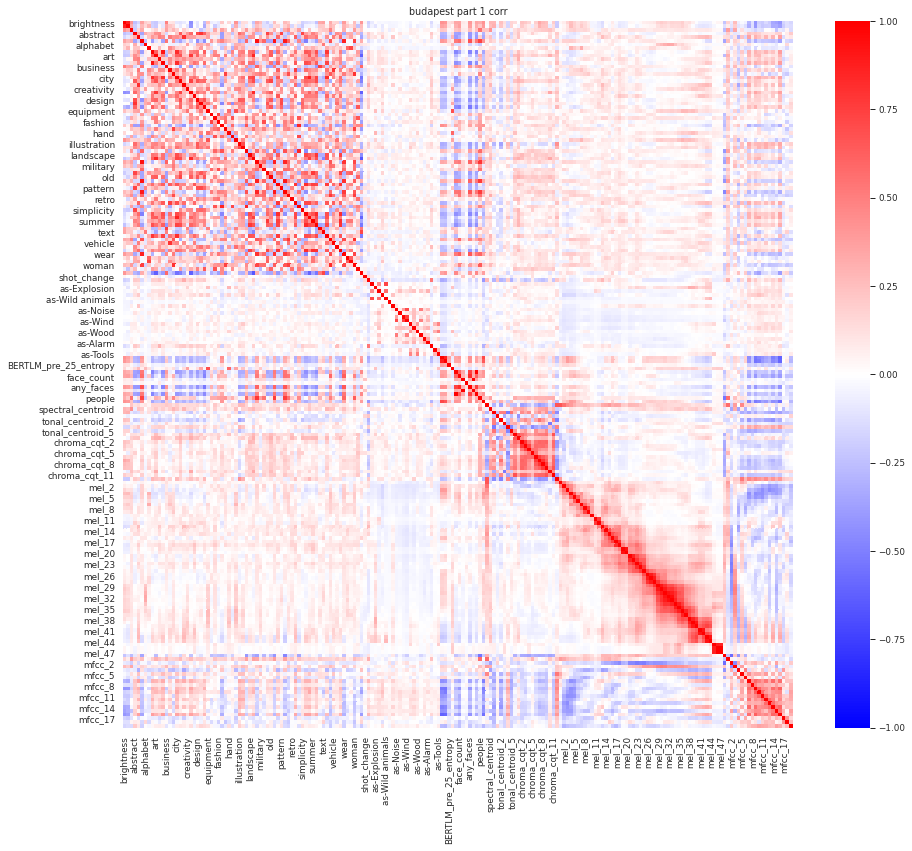

In [85]:
df_corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, cmap = 'bwr', vmin=-1, vmax=1)
plt.title("budapest part 1 corr")

## calculate dcor

In [77]:
import dcor
%time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
dcor_matrix = result.values

CPU times: user 10min 28s, sys: 136 ms, total: 10min 28s
Wall time: 10min 29s


## plot dcor matrix

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(result, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(result, cmap = 'bwr', vmin=0, vmax=1, center=0)
plt.title("budapest part 1 dcor")


# mask = np.triu(np.ones_like(result, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(15, 12))

# # Generate a custom diverging colormap
# #cmap = sns.diverging_palette(230, 20, as_cmap=True)
# cmap = 'bwr'

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(result, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
#             square=True, linewidths=.5, annot=True, fmt=".2g",  cbar_kws={"shrink": .5})
# plt.title('Distance Correlation')

## DCOR: sort the matrix after hierarchical clustering for block diagonal structure

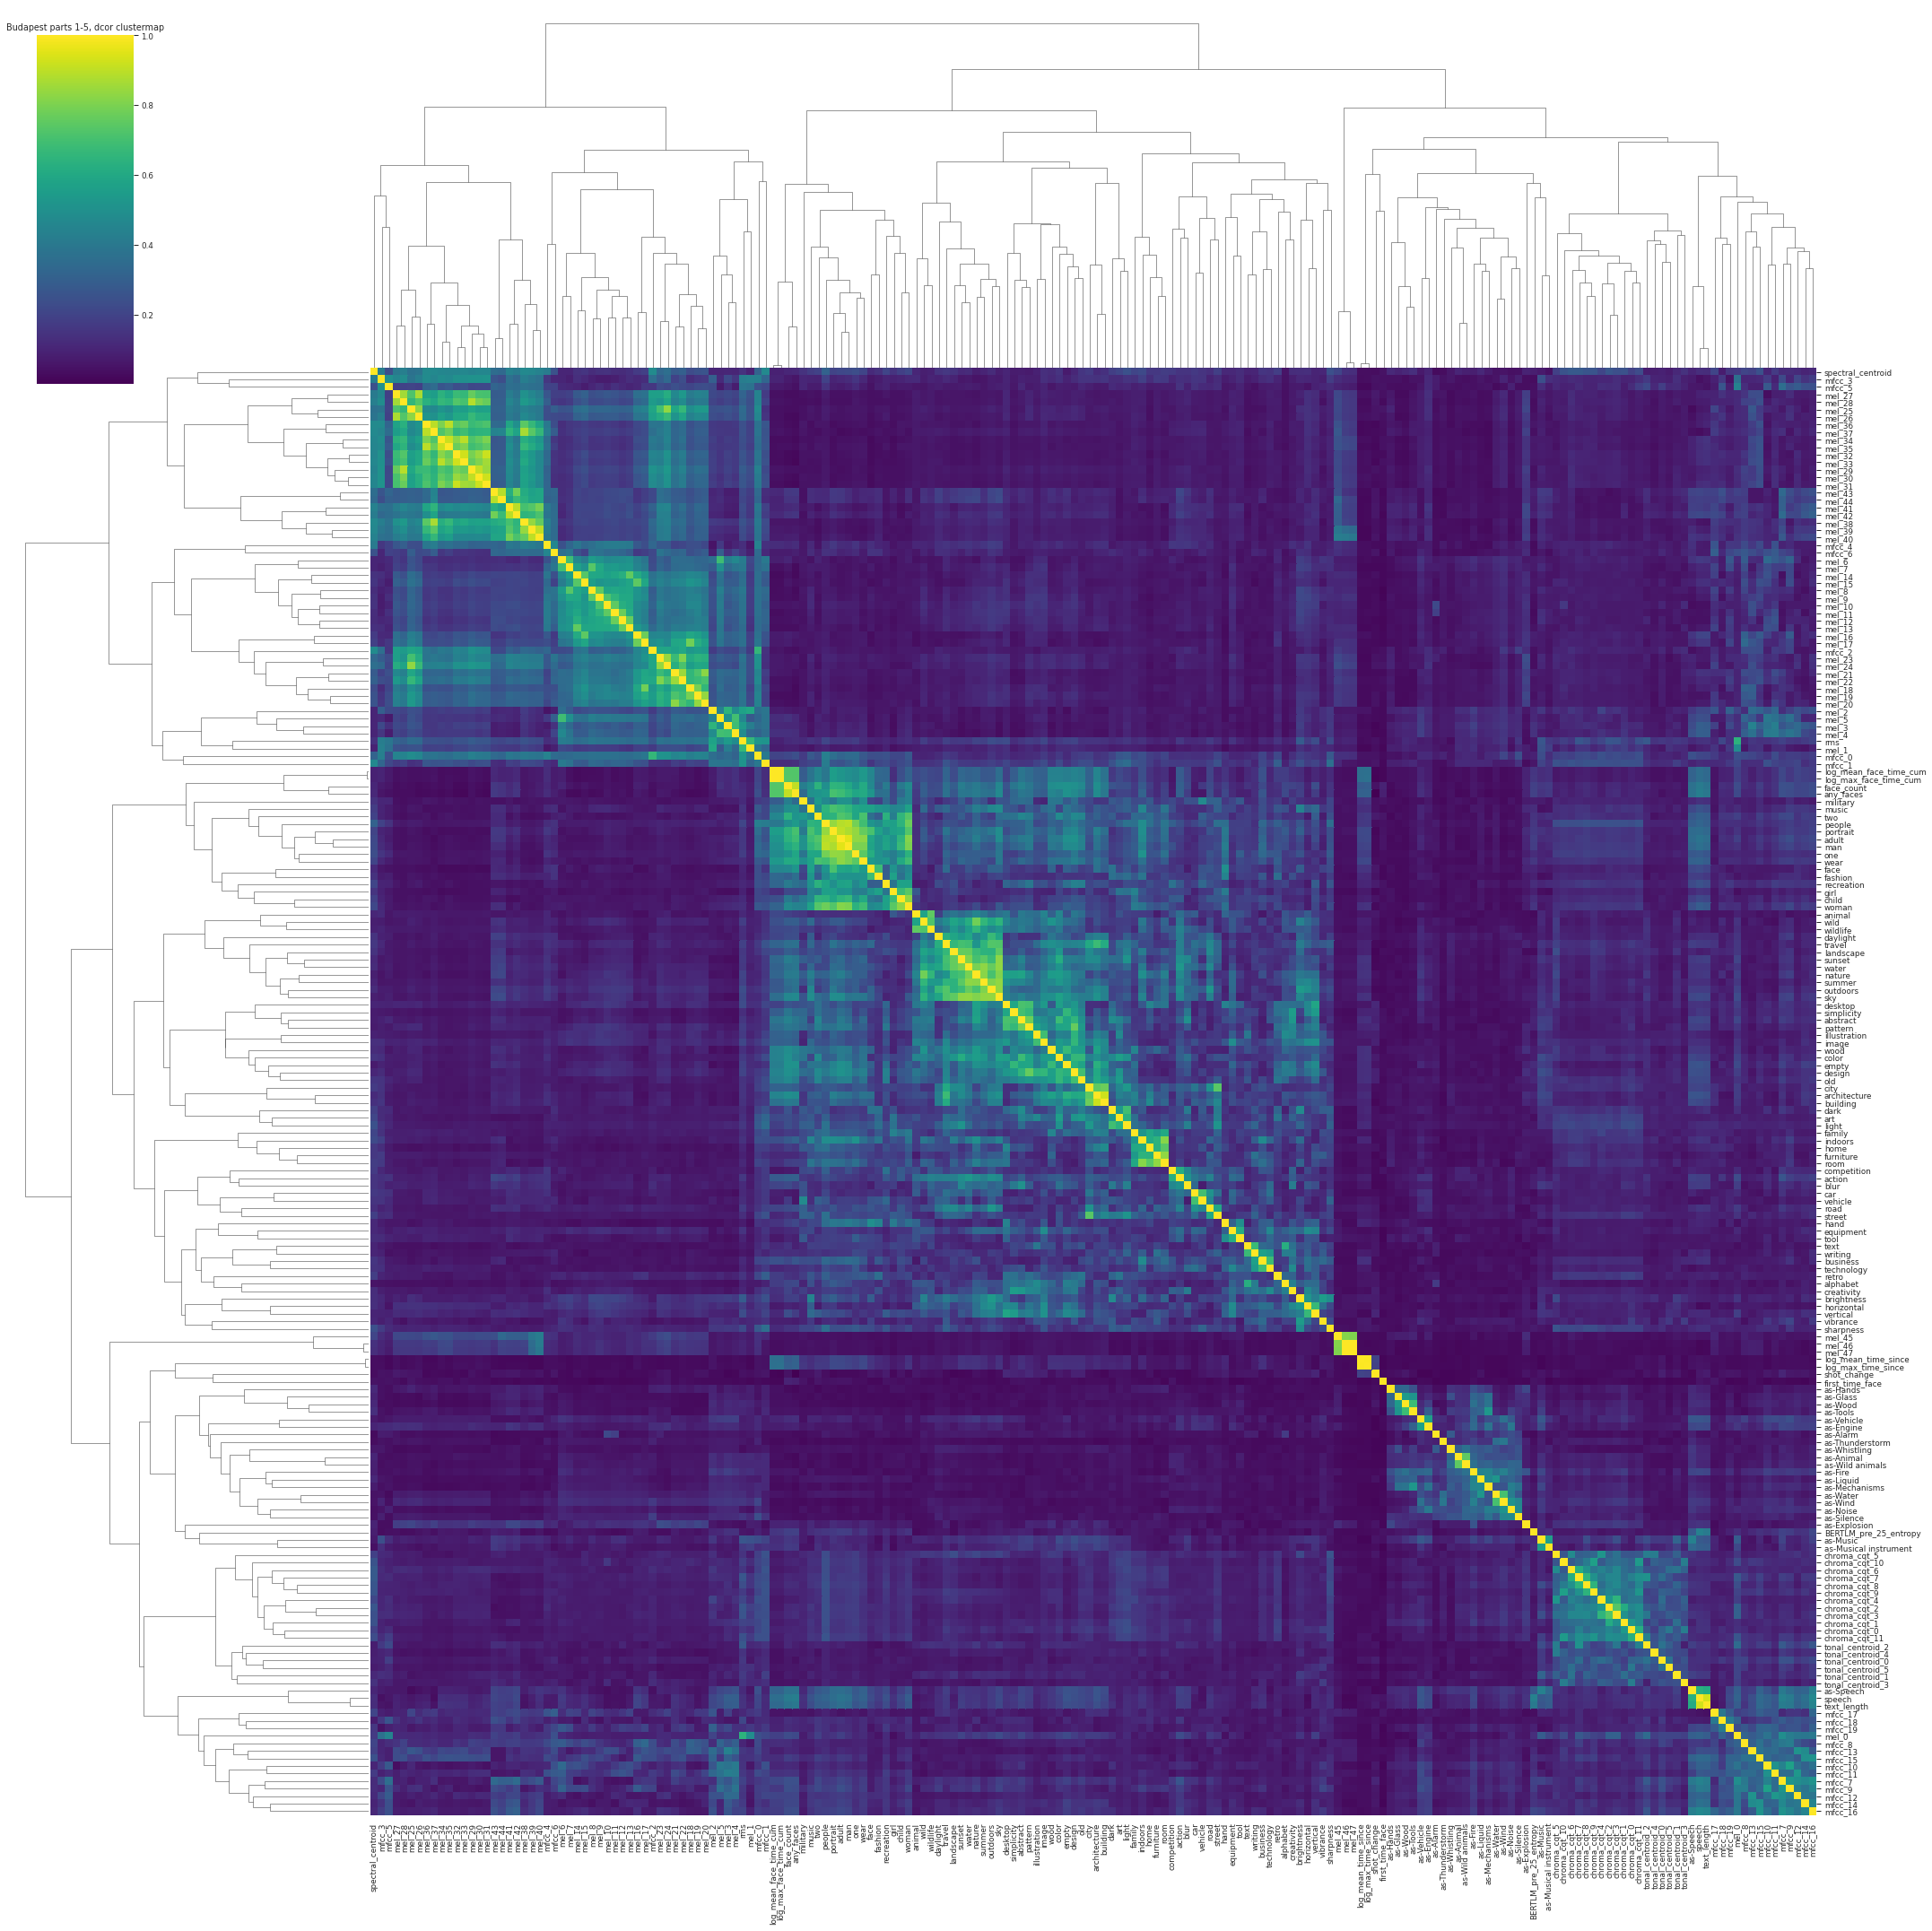

In [109]:
sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
plt.title('Budapest parts 1-5, dcor clustermap')
plt.savefig('../outputs/dcor_budapes_all.png')
# sns.clustermap(result, cmap="mako",
#                row_colors=network_colors, col_colors=network_colors,
#                linewidths=.75, figsize=(13, 13))

## hierarchical clustering from sklearn

In [23]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [92]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [101]:
# model = AgglomerativeClustering(distance_threshold=0.1, n_clusters=None, linkage= 'complete', affinity='precomputed')
# model.fit(result)

model = AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage= 'complete', affinity='precomputed')
model.fit(result)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=4)

In [102]:
model.labels_

array([0, 3, 1, 0, 2, 3, 1, 3, 2, 0, 3, 3, 1, 3, 0, 0, 0, 0, 2, 2, 1, 3,
       0, 1, 0, 2, 2, 0, 0, 1, 1, 3, 1, 1, 0, 0, 3, 1, 1, 2, 0, 0, 0, 2,
       0, 3, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 2, 1, 1, 1,
       1, 0, 3, 1, 0, 1, 1, 1, 2, 3, 1, 0, 2, 2, 2, 2, 0, 0, 1, 3, 1, 0,
       0, 3, 0, 1, 2, 3, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 3, 0, 1, 3,
       1, 3, 1, 1, 0, 1, 2, 1, 3, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 3, 1,
       0, 3, 1, 3, 2, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 1, 0, 2,
       1, 0, 3, 1, 2, 0, 1, 2, 3, 0, 2, 1, 3, 0, 1, 0, 3, 1, 3, 1, 0, 1,
       0, 0, 2, 1, 1, 3, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1])

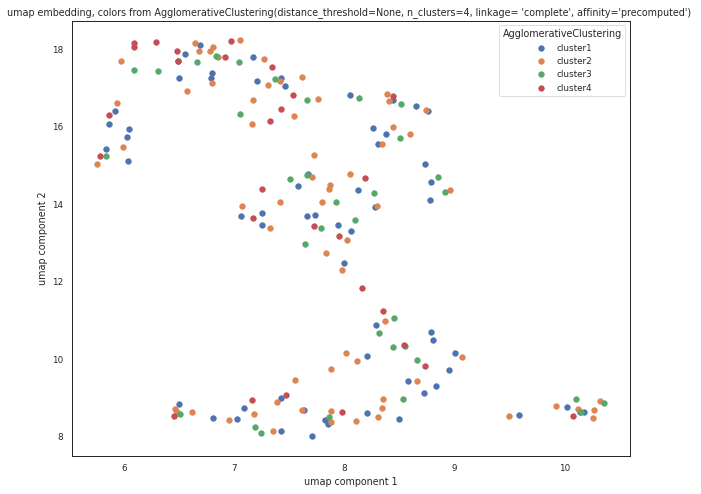

In [104]:
fig, ax = plt.subplots(figsize=((10,8)))
cdict = {0: 'cluster1', 1: 'cluster2', 2: 'cluster3', 3: 'cluster4'}

for category in np.unique(model.labels_):
    ix = np.where(model.labels_ == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 30, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding, colors from AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage= \'complete\', affinity=\'precomputed\') ')
#plt.colorbar();
ax.legend(title="AgglomerativeClustering")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

In [ ]:
#plot_dendrogram(model)
plot_dendrogram(model, truncate_mode='level', p=4)

### try umap

In [20]:
import umap
# n_neighbors=25
# min_dist=0
# n_components=2
# metric='euclidean'

# fit = umap.UMAP(n_neighbors=n_neighbors,
#     min_dist=min_dist,
#     n_components=n_components,
#     metric=metric)

umap=umap.UMAP(metric='correlation',random_state=42)

#%time u = fit.fit_transform(all_data[:,:,0])


In [21]:
%time u = umap.fit_transform(df.T)

CPU times: user 9.22 s, sys: 113 ms, total: 9.33 s
Wall time: 9.3 s


In [22]:
predictor_modality_ind = np.zeros(predictor_modality.shape)

In [23]:
predictor_modality_int = np.where(predictor_modality == None, '', predictor_modality)

In [24]:
modality_lookup, foo, modality_inverse= np.unique(predictor_modality_int,return_index=True,return_inverse=True)

In [25]:
modality_lookup

array(['', 'audio', 'image', 'text'], dtype=object)

In [26]:
modality_inverse

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

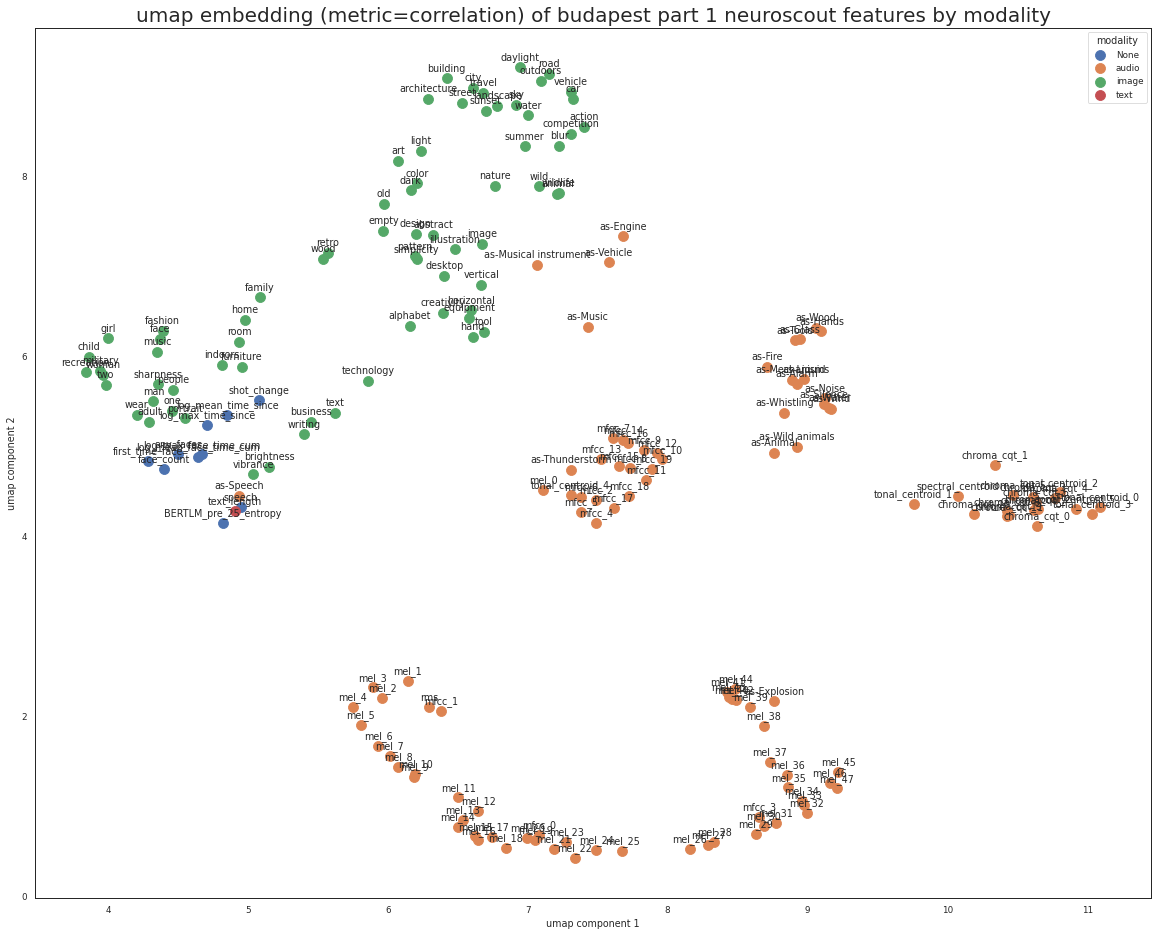

In [28]:
fig, ax = plt.subplots(figsize=((20,16)))
cdict = {0: 'None', 1: 'audio', 2: 'image', 3: 'text'}


for category in np.unique(modality_inverse):
    ix = np.where(modality_inverse == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features by modality',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="modality")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## lets turn the distance correlation matrix into an undirected graph and find a good threshold

In [29]:
import networkx as nx

In [30]:
dcor_matrix = result.values

In [31]:
np.fill_diagonal(dcor_matrix, 0) 

In [32]:
dcor_matrix_g = nx.Graph(incoming_graph_data=dcor_matrix)
mapping = dict(zip(dcor_matrix_thresh_g, budapest_predictor_names))
dcor_matrix_thresh_g = nx.relabel_nodes(dcor_matrix_thresh_g, mapping) 

plt.figure(figsize=(20,20))
plt.title(f'budapest part 1 - undirected graph from dcor')
nx.draw(dcor_matrix_thresh_g, alpha = 0.7, node_size=200, node_color=modality_inverse/3, with_labels=True, font_size=15)
#plt.show()

NameError: name 'dcor_matrix_thresh_g' is not defined

In [33]:
thresh=0.15

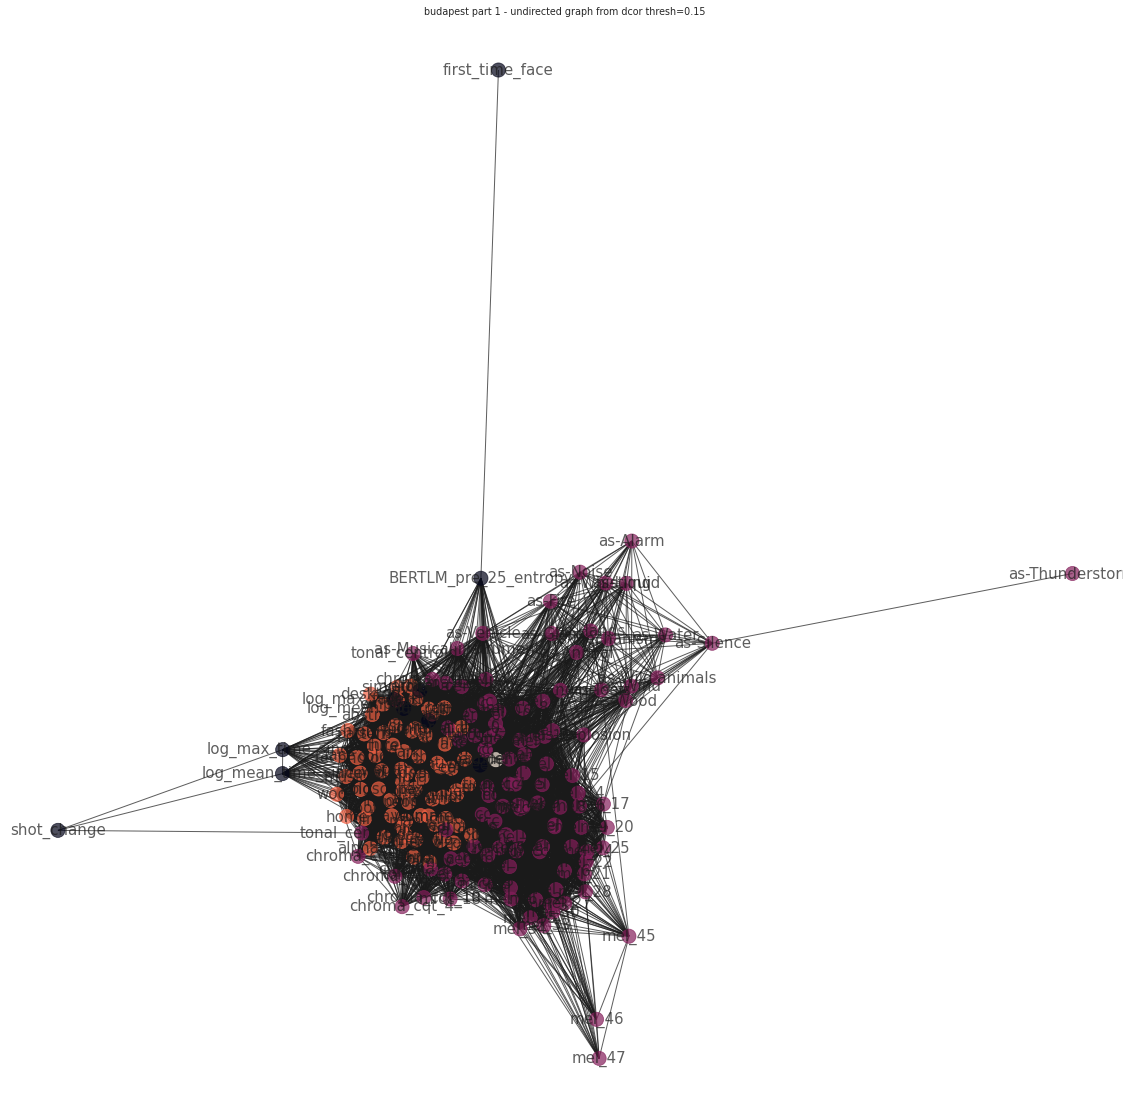

In [35]:
dcor_matrix_thresh=np.where(dcor_matrix>thresh,1,0)

dcor_matrix_thresh_g = nx.Graph(incoming_graph_data=dcor_matrix_thresh)
mapping = dict(zip(dcor_matrix_thresh_g, predictor_names))
dcor_matrix_thresh_g = nx.relabel_nodes(dcor_matrix_thresh_g, mapping) 

plt.figure(figsize=(20,20))
plt.title(f'budapest part 1 - undirected graph from dcor thresh={str(thresh)}')
nx.draw(dcor_matrix_thresh_g, alpha = 0.7, node_size=200, node_color=modality_inverse/3, with_labels=True, font_size=15)
#plt.show()

In [38]:
nx.algorithms.community.quality.modularity(dcor_matrix_thresh_g)

TypeError: modularity() missing 1 required positional argument: 'communities'

## Use Communities to look at community structure

### Louvain method:

In [39]:
from communities.visualization import draw_communities
from communities.algorithms import louvain_method

In [40]:
communities, frames = louvain_method(dcor_matrix)

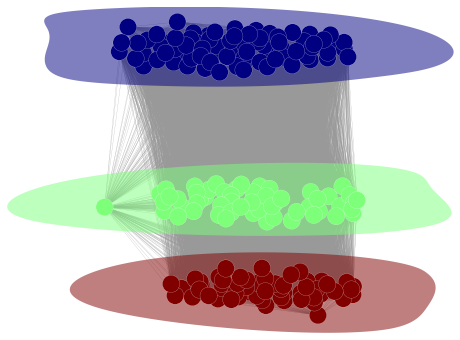

<AxesSubplot:>

In [88]:
draw_communities(dcor_matrix, communities)

In [89]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

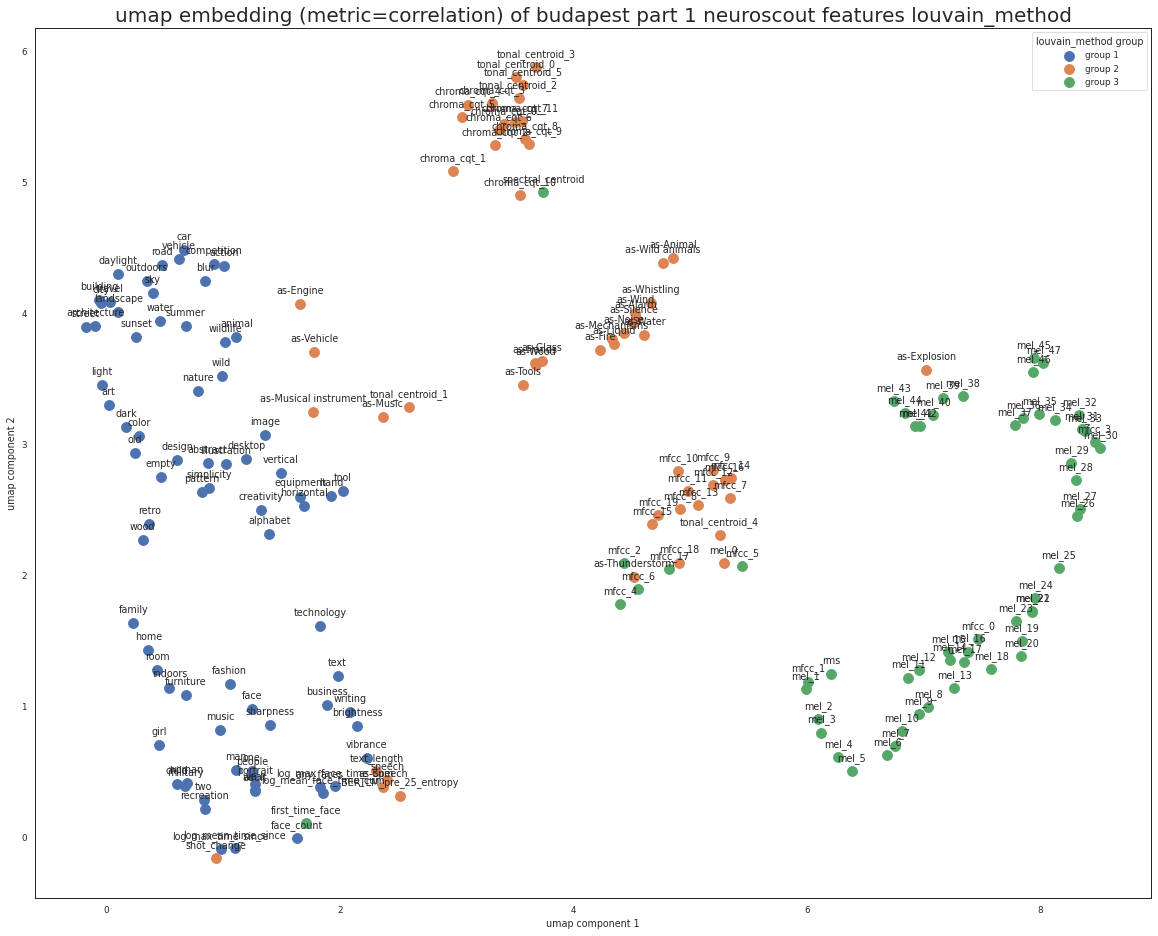

In [90]:
fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features louvain_method',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="louvain_method group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## Girvan Newman

In [109]:
from communities.algorithms import girvan_newman

In [ ]:
communities, frames = girvan_newman(dcor_matrix)

In [ ]:
len(communities)

In [ ]:
draw_communities(dcor_matrix, communities)

In [ ]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

In [ ]:
budapest_predictor_ids.shape

In [ ]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features girvan_newman',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="girvan_newman group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## Hierarchichal CLustering

In [91]:
from communities.algorithms import hierarchical_clustering

In [92]:
communities = hierarchical_clustering(dcor_matrix,n=5)

In [93]:
len(communities)

5

/om2/user/jsmentch/anaconda/envs/pliers/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][8]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/om2/user/jsmentch/anaconda/envs/pliers/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][8]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


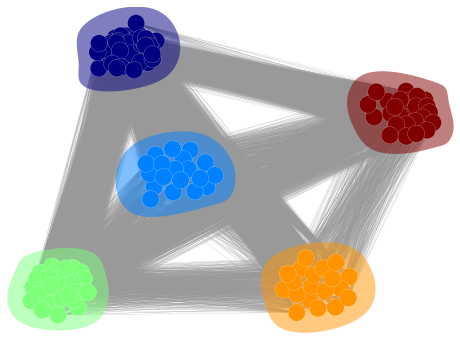

<AxesSubplot:>

In [94]:
draw_communities(dcor_matrix, communities)

In [95]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

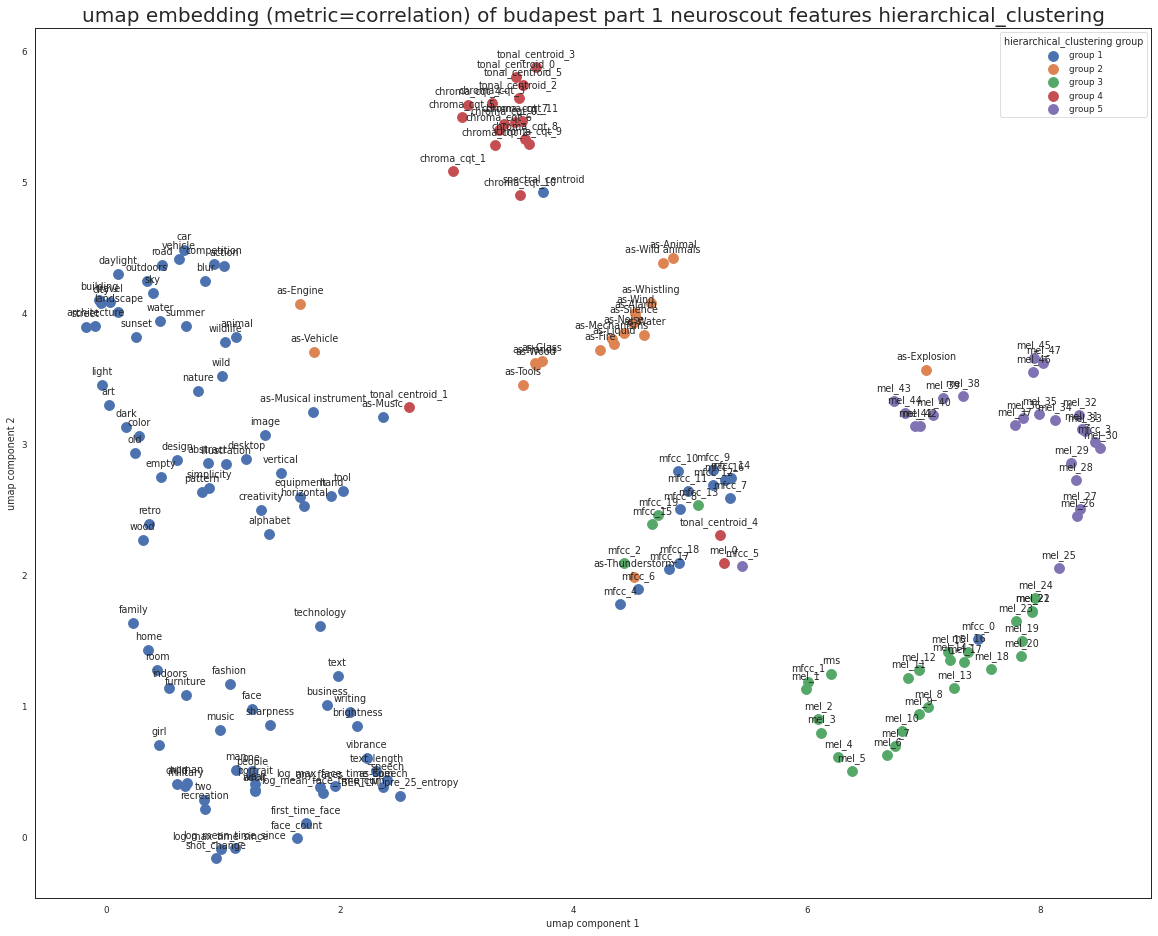

In [96]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features hierarchical_clustering',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="hierarchical_clustering group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## spectral_clustering

In [97]:
from communities.algorithms import spectral_clustering

In [104]:
communities = spectral_clustering(dcor_matrix,k=5)

In [105]:
len(communities)

5

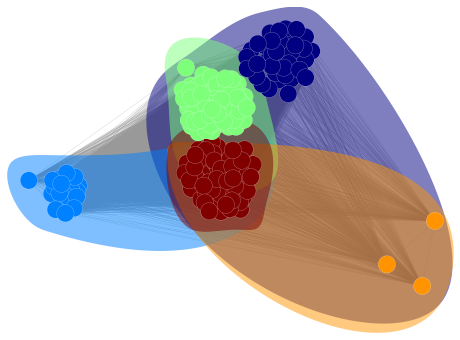

<AxesSubplot:>

In [106]:
draw_communities(dcor_matrix, communities)

In [107]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

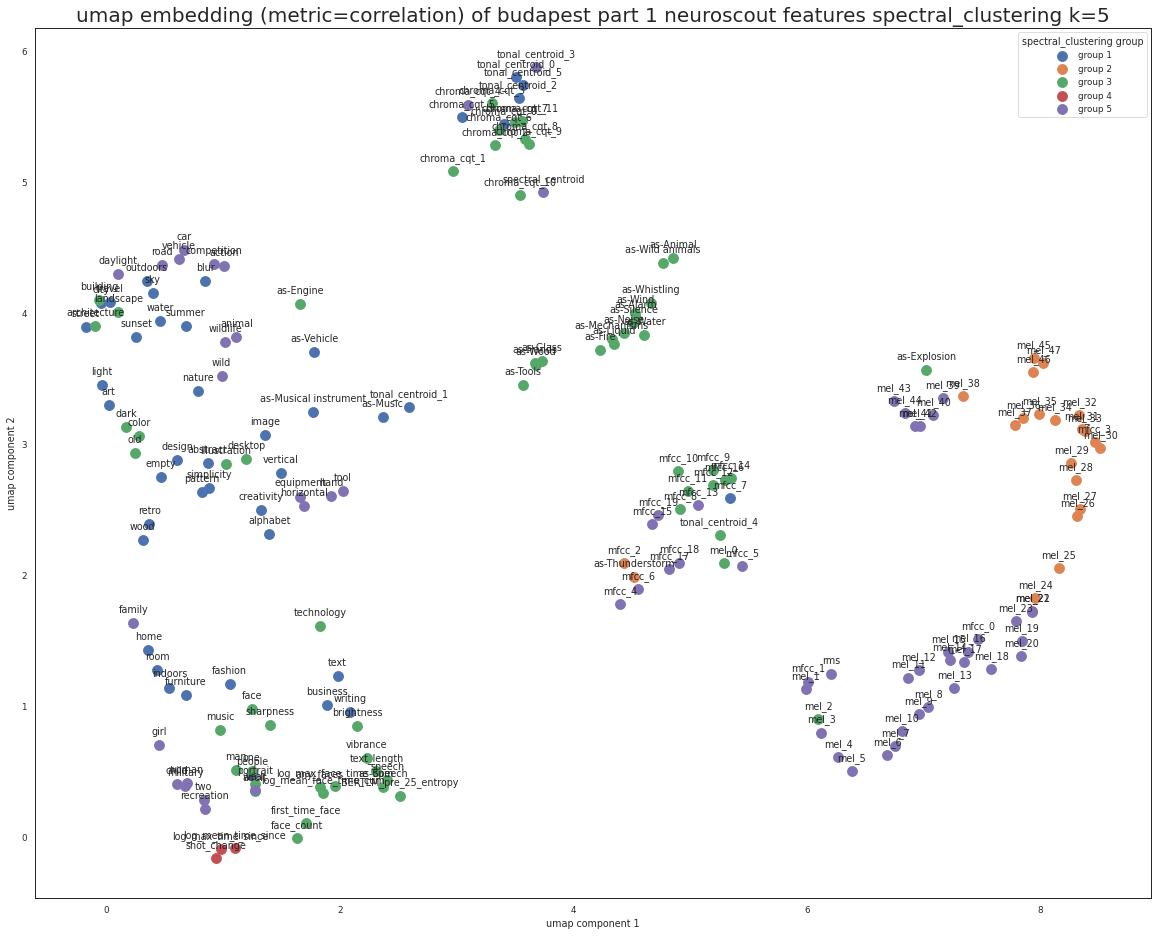

In [108]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features spectral_clustering k=5',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="spectral_clustering group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## bron_kerbosch

In [58]:
from communities.algorithms import bron_kerbosch

In [62]:
communities = bron_kerbosch(dcor_matrix, pivot=True)

In [60]:
len(communities)

0

In [ ]:
draw_communities(dcor_matrix_thresh, communities)

In [ ]:
communities_plot=np.zeros(modality_inverse.shape)
cdict = {}

for i,c in enumerate(communities):
    cdict[i]=f'group {i+1}'
    for c_c in list(communities[i]):
        communities_plot[c_c]=i

In [ ]:

fig, ax = plt.subplots(figsize=((20,16)))
for category in np.unique(communities_plot):
    ix = np.where(communities_plot == category)
    ax.scatter(u[:, 0][ix], u[:, 1][ix], label = cdict[category], s = 100, alpha = 1, cmap = 'gist_rainbow')
#     plt.scatter(projected[:, 0], projected[:, 1],
#             alpha=0.8, c=as_classes, label=as_classes_label,cmap = 'gist_rainbow')
for i,s in enumerate(budapest_predictor_names):
    plt.text(u[i,0],u[i,1]+0.08,s,ha='center')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')
plt.title('umap embedding (metric=correlation) of budapest part 1 neuroscout features bron_kerbosch',fontdict = {'fontsize' : 20})
#plt.colorbar();
ax.legend(title="bron_kerbosch group")
# plt.xlim((-0.2,1))
# plt.ylim((-0.2,0.5))

## take a feature and get the mean value and compare it across all datasets

In [5]:
api.predictors.get(name='speech', newest=True)

[{'dataset_id': 28,
  'description': 'Speech (binarized, on or off)',
  'extracted_feature': {'created_at': '2021-03-03 21:01:58.071706',
   'description': 'Speech (binarized, on or off)',
   'extractor_name': 'ComplexTextExtractor',
   'id': 425657,
   'modality': None,
   'resample_frequency': None},
  'id': 39215,
  'max': 1.0,
  'mean': 1.0,
  'min': 1.0,
  'name': 'speech',
  'num_na': 0,
  'private': False,
  'source': 'extracted'}]